![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [221]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [222]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

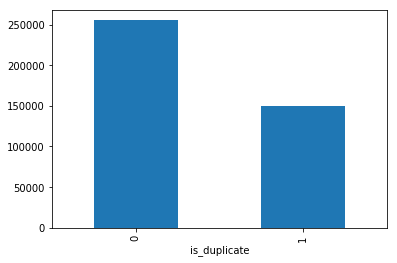

In [224]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [225]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [226]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [227]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



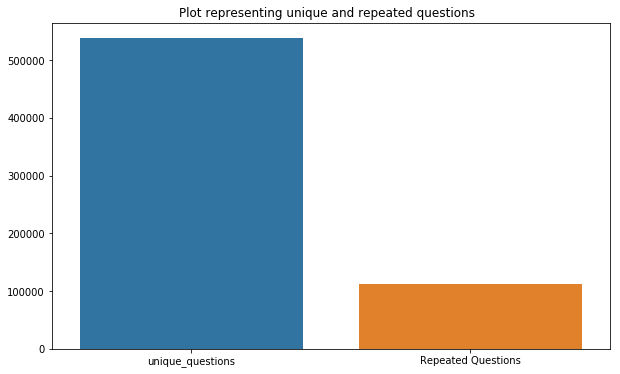

In [228]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [229]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



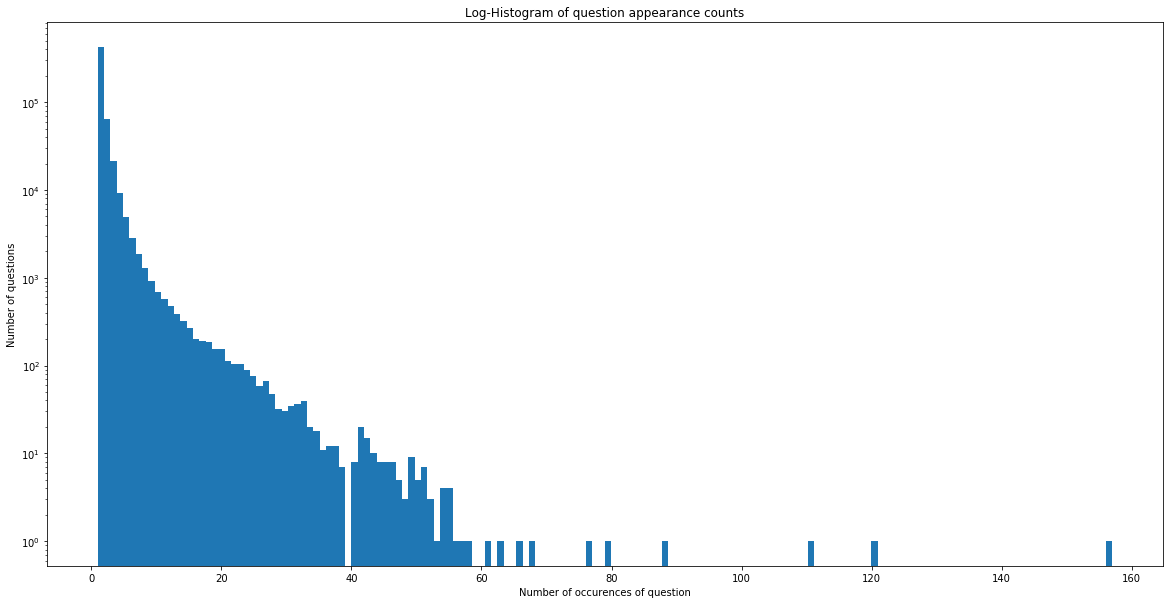

In [230]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [231]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [232]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [233]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [234]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

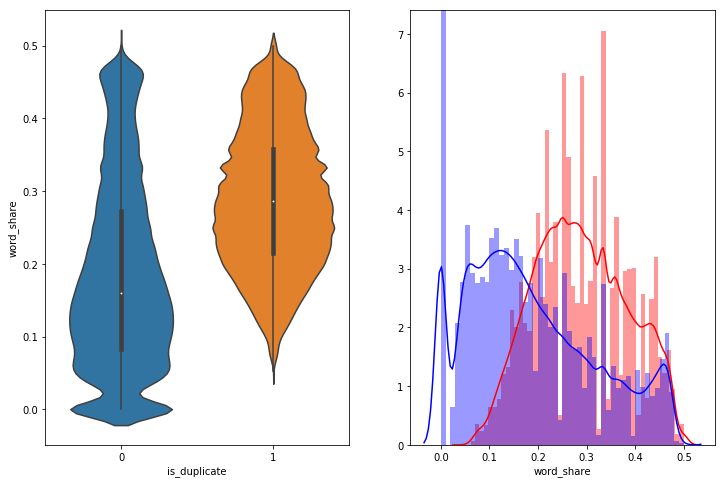

In [235]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

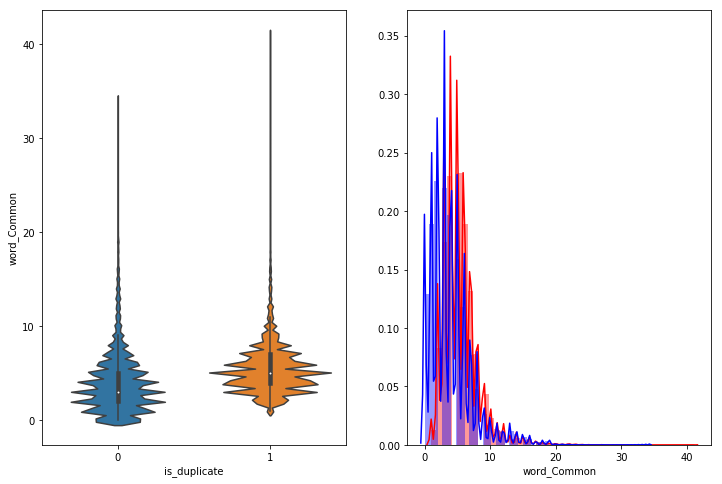

In [236]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [237]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [238]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [239]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [240]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [241]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [242]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [243]:
df.shape

(404290, 21)

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [244]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [245]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33194892


Word Cloud for Duplicate Question pairs


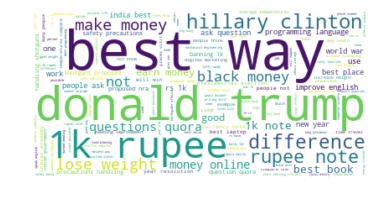

In [246]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


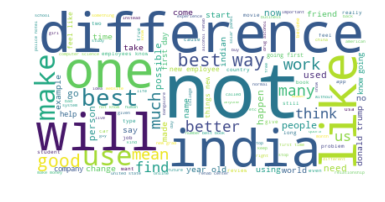

In [247]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

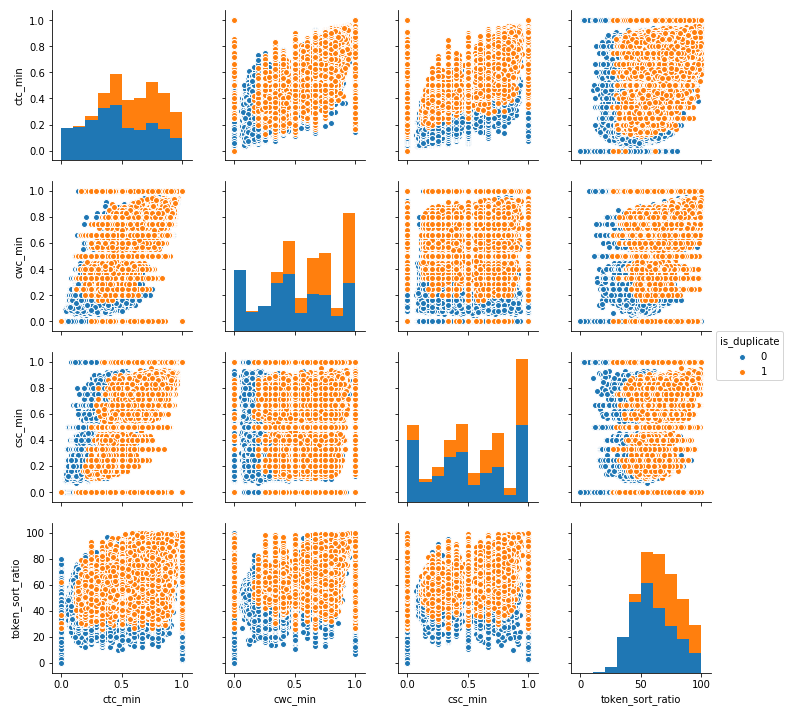

In [248]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

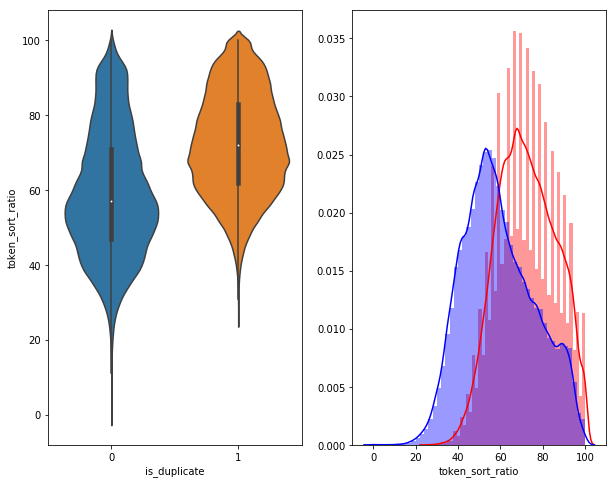

In [249]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

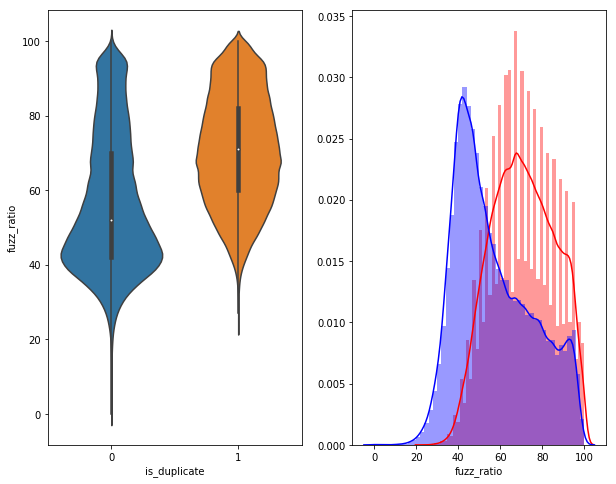

In [250]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [251]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [252]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.423s...
[t-SNE] Computed neighbors for 5000 samples in 0.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.451s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 4.861s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 2.696s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 2.820s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 2.844s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

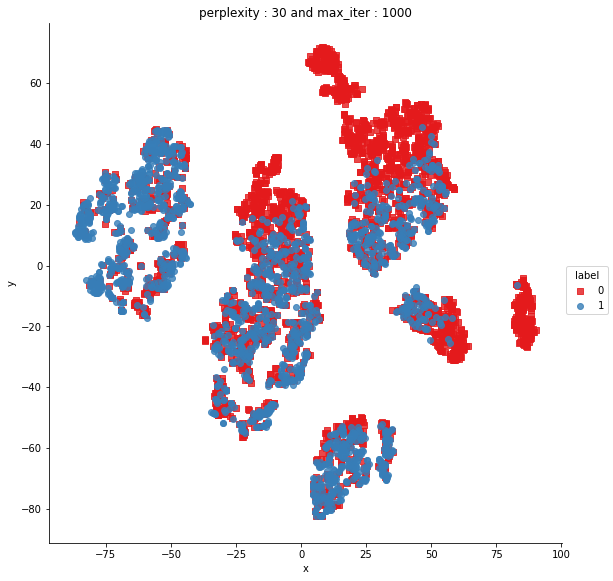

In [253]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [254]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 0.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.240s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 9.612s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 5.274s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 5.105s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 4.946s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.0009272

In [255]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [127]:
df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [128]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [129]:
df.columns.values

array(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'], dtype=object)

In [130]:
labels=df['is_duplicate']
df.drop(['is_duplicate'],axis=1,inplace=True)
df.head(2)

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [131]:
#labels=labels.head(100000)

In [132]:
#df=df[0:100000]

In [133]:
from sklearn.model_selection import train_test_split
project_data_train, project_data_test, labels_train, labels_test = train_test_split(df, labels , test_size=0.3, stratify=labels)
print(project_data_train.shape)
print(project_data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(283003, 20)
(121287, 20)
(283003,)
(121287,)


### Pre Processing Text Data - Train

In [134]:
project_data_train["question"] = project_data_train["question1"].map(str) +\
                                 project_data_train["question2"].map(str)

In [135]:
print(project_data_train['question'].values[0])
print("="*50)

what major should i choose in university what major should i choose 


In [136]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [137]:
sent = decontracted(project_data_train['question'].values[0])
print(sent)
print("="*50)

what major should i choose in university what major should i choose 


In [138]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

what major should i choose in university what major should i choose 


In [139]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

what major should i choose in university what major should i choose 


In [140]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [141]:
# Combining all the above stundents 
from collections import Counter
from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data_train['question'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_question.append(sent.lower().strip())
    
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in preprocessed_question:
    my_counter.update(word.split())
    
essay_dict = dict(my_counter)
sorted_essays_dict = dict(sorted(essay_dict.items(), key=lambda kv: kv[1]))

100%|███████████████████████████████████████████████████████████████████████| 283003/283003 [00:17<00:00, 16448.30it/s]


In [142]:
preprocessed_question[0]

'major choose university major choose'

### Pre Processing Text Data - Test

In [143]:
project_data_test["question"] = project_data_test["question1"].map(str) +\
                                 project_data_test["question2"].map(str)

In [144]:
print(project_data_test['question'].values[0])
print("="*50)

why has this recruiter from amazon stopped replying after he told me that i have cleared the 1st round my google recruiter told me he should have updates for me today since the hiring committee reviewed my packet this week  why did not i get an update 


In [145]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [146]:
sent = decontracted(project_data_test['question'].values[0])
print(sent)
print("="*50)

why has this recruiter from amazon stopped replying after he told me that i have cleared the 1st round my google recruiter told me he should have updates for me today since the hiring committee reviewed my packet this week  why did not i get an update 


In [147]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

why has this recruiter from amazon stopped replying after he told me that i have cleared the 1st round my google recruiter told me he should have updates for me today since the hiring committee reviewed my packet this week  why did not i get an update 


In [148]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

why has this recruiter from amazon stopped replying after he told me that i have cleared the 1st round my google recruiter told me he should have updates for me today since the hiring committee reviewed my packet this week why did not i get an update 


In [149]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [150]:
# Combining all the above stundents 
from collections import Counter
from tqdm import tqdm
preprocessed_question_test = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data_test['question'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_question_test.append(sent.lower().strip())
    
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in preprocessed_question_test:
    my_counter.update(word.split())
    
essay_dict = dict(my_counter)
sorted_essays_dict = dict(sorted(essay_dict.items(), key=lambda kv: kv[1]))

100%|███████████████████████████████████████████████████████████████████████| 121287/121287 [00:06<00:00, 17356.73it/s]


In [151]:
preprocessed_question_test[0]

'recruiter amazon stopped replying told cleared 1st round google recruiter told updates today since hiring committee reviewed packet week not get update'

### Vectorizing Text Data

#### For Train

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False, binary=True)
text_tfidf = vectorizer.fit_transform(preprocessed_question)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (283003, 73472)


#### For Test

In [153]:
#vectorizer.fit(preprocessed_question_test)
text_tfidf_test = vectorizer.transform(preprocessed_question_test)
print("Shape of matrix after one hot encodig ",text_tfidf_test.shape)

Shape of matrix after one hot encodig  (121287, 73472)


### Vectorizing Numerical Features

#### Train Data

In [154]:
from sklearn.preprocessing import StandardScaler
Qid1_scalar = StandardScaler()
Qid1_scalar.fit_transform(project_data_train['qid1'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
Qid1_standardized = Qid1_scalar.transform(project_data_train['qid1'].values.reshape(-1, 1))

In [155]:
Qid1_standardized

array([[ 1.86250868],
       [-1.17219974],
       [-1.23991328],
       ...,
       [ 1.11035237],
       [ 1.29698168],
       [-0.35893315]])

In [156]:
from sklearn.preprocessing import StandardScaler
Qid2_scalar = StandardScaler()
Qid2_scalar.fit_transform(project_data_train['qid2'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
Qid2_standardized = Qid2_scalar.transform(project_data_train['qid2'].values.reshape(-1, 1))
Qid2_standardized

array([[ 1.81250051],
       [-0.78936019],
       [-1.24480366],
       ...,
       [ 1.07159995],
       [ 1.25554035],
       [-0.33709889]])

In [157]:
from sklearn.preprocessing import StandardScaler
cwc_min_scalar = StandardScaler()
cwc_min_scalar.fit_transform(project_data_train['cwc_min'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
cwc_min_standardized = cwc_min_scalar.transform(project_data_train['cwc_min'].values.reshape(-1, 1))
cwc_min_standardized

array([[ 1.33358656],
       [ 0.25559918],
       [-1.90048339],
       ...,
       [ 1.33358656],
       [-1.09194569],
       [ 0.52512971]])

In [158]:
from sklearn.preprocessing import StandardScaler
cwc_max_scalar = StandardScaler()
cwc_max_scalar.fit_transform(project_data_train['cwc_max'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
cwc_max_standardized = cwc_max_scalar.transform(project_data_train['cwc_max'].values.reshape(-1, 1))
cwc_max_standardized

array([[ 0.75785534],
       [-0.45885597],
       [-1.67560783],
       ...,
       [ 0.75785534],
       [-1.1541415 ],
       [ 0.51453822]])

In [159]:
from sklearn.preprocessing import StandardScaler
csc_min_scalar = StandardScaler()
csc_min_scalar.fit_transform(project_data_train['csc_min'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
csc_min_standardized = csc_min_scalar.transform(project_data_train['csc_min'].values.reshape(-1, 1))
csc_min_standardized

array([[ 1.27240898],
       [-1.70135338],
       [-0.21449698],
       ...,
       [-1.70135338],
       [-0.95790659],
       [ 0.67768823]])

In [160]:
from sklearn.preprocessing import StandardScaler
csc_max_scalar = StandardScaler()
csc_max_scalar.fit_transform(project_data_train['csc_max'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
csc_max_standardized = cwc_max_scalar.transform(project_data_train['csc_max'].values.reshape(-1, 1))
csc_max_standardized

array([[ 1.06206105],
       [-1.67560783],
       [-1.1541415 ],
       ...,
       [-1.67560783],
       [-0.94555914],
       [ 0.7578959 ]])

In [161]:
from sklearn.preprocessing import StandardScaler
ctc_min_scalar = StandardScaler()
ctc_min_scalar.fit_transform(project_data_train['ctc_min'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
ctc_min_standardized = csc_min_scalar.transform(project_data_train['ctc_min'].values.reshape(-1, 1))
ctc_min_standardized

array([[ 1.27244863],
       [-0.71008274],
       [-1.10659298],
       ...,
       [-0.21445981],
       [-1.04050261],
       [ 0.38032885]])

In [162]:
from sklearn.preprocessing import StandardScaler
ctc_max_scalar = StandardScaler()
ctc_max_scalar.fit_transform(project_data_train['ctc_max'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
ctc_max_standardized = cwc_max_scalar.transform(project_data_train['ctc_max'].values.reshape(-1, 1))
ctc_max_standardized

array([[ 0.9317238 ],
       [-1.15413778],
       [-1.44746448],
       ...,
       [-0.45885597],
       [-1.01191997],
       [ 0.87958812]])

In [163]:
from sklearn.preprocessing import StandardScaler
last_word_eq_scalar = StandardScaler()
last_word_eq_scalar.fit_transform(project_data_train['last_word_eq'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
last_word_eq_standardized = cwc_max_scalar.transform(project_data_train['last_word_eq'].values.reshape(-1, 1))
last_word_eq_standardized

array([[-1.67560783],
       [ 1.9747086 ],
       [-1.67560783],
       ...,
       [ 1.9747086 ],
       [-1.67560783],
       [ 1.9747086 ]])

In [164]:
from sklearn.preprocessing import StandardScaler
first_word_eq_scalar = StandardScaler()
first_word_eq_scalar.fit_transform(project_data_train['first_word_eq'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
first_word_eq_standardized = cwc_max_scalar.transform(project_data_train['first_word_eq'].values.reshape(-1, 1))
first_word_eq_standardized

array([[ 1.9747086 ],
       [-1.67560783],
       [ 1.9747086 ],
       ...,
       [-1.67560783],
       [-1.67560783],
       [ 1.9747086 ]])

In [165]:
from sklearn.preprocessing import StandardScaler
abs_len_diff_scalar = StandardScaler()
abs_len_diff_scalar.fit_transform(project_data_train['abs_len_diff'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
abs_len_diff_standardized = cwc_max_scalar.transform(project_data_train['abs_len_diff'].values.reshape(-1, 1))
abs_len_diff_standardized

array([[ 5.62502502],
       [27.52692356],
       [38.47787283],
       ...,
       [ 5.62502502],
       [ 5.62502502],
       [-1.67560783]])

In [166]:
from sklearn.preprocessing import StandardScaler
mean_len_scalar = StandardScaler()
mean_len_scalar.fit_transform(project_data_train['mean_len'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
mean_len_standardized = cwc_max_scalar.transform(project_data_train['mean_len'].values.reshape(-1, 1))
mean_len_standardized

array([[20.22629071],
       [34.82755641],
       [36.65271462],
       ...,
       [16.57597429],
       [34.82755641],
       [34.82755641]])

In [167]:
from sklearn.preprocessing import StandardScaler
token_set_ratio_scalar = StandardScaler()
token_set_ratio_scalar.fit_transform(project_data_train['token_set_ratio'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
token_set_ratio_standardized = cwc_max_scalar.transform(project_data_train['token_set_ratio'].values.reshape(-1, 1))
token_set_ratio_standardized

array([[363.35603452],
       [246.54590897],
       [137.03641626],
       ...,
       [301.30065532],
       [169.88926408],
       [290.34970605]])

In [168]:
from sklearn.preprocessing import StandardScaler
token_sort_ratio_scalar = StandardScaler()
token_sort_ratio_scalar.fit_transform(project_data_train['token_sort_ratio'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
token_sort_ratio_standardized = cwc_max_scalar.transform(project_data_train['token_sort_ratio'].values.reshape(-1, 1))
token_sort_ratio_standardized

array([[286.69938963],
       [188.14084619],
       [129.73578342],
       ...,
       [286.69938963],
       [169.88926408],
       [242.89559254]])

In [169]:
from sklearn.preprocessing import StandardScaler
fuzz_ratio_scalar = StandardScaler()
fuzz_ratio_scalar.fit_transform(project_data_train['fuzz_ratio'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
fuzz_ratio_standardized = cwc_max_scalar.transform(project_data_train['fuzz_ratio'].values.reshape(-1, 1))
fuzz_ratio_standardized

array([[286.69938963],
       [188.14084619],
       [118.78483415],
       ...,
       [286.69938963],
       [137.03641626],
       [283.0490732 ]])

In [170]:
from sklearn.preprocessing import StandardScaler
fuzz_partial_ratio_scalar = StandardScaler()
fuzz_partial_ratio_scalar.fit_transform(project_data_train['fuzz_partial_ratio'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
fuzz_partial_ratio_standardized = cwc_max_scalar.transform(project_data_train['fuzz_partial_ratio'].values.reshape(-1, 1))
fuzz_partial_ratio_standardized

array([[363.35603452],
       [257.49685824],
       [166.23894765],
       ...,
       [304.95097174],
       [166.23894765],
       [279.39875678]])

In [171]:
from sklearn.preprocessing import StandardScaler
longest_substr_ratio_scalar = StandardScaler()
longest_substr_ratio_scalar.fit_transform(project_data_train['longest_substr_ratio'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
longest_substr_ratio_standardized = cwc_max_scalar.transform(project_data_train['longest_substr_ratio'].values.reshape(-1, 1))
longest_substr_ratio_standardized

array([[ 1.84434015],
       [-0.42407077],
       [-1.13482021],
       ...,
       [ 0.9919311 ],
       [-1.05427737],
       [-0.48366777]])

#### Test Data

In [172]:
Qid1_test_standardized = Qid1_scalar.transform(project_data_test['qid1'].values.reshape(-1, 1))
Qid1_test_standardized

array([[-0.55712609],
       [ 0.84527051],
       [-1.07530753],
       ...,
       [-0.9720975 ],
       [ 1.88719637],
       [ 1.56522879]])

In [173]:
Qid2_test_standardized = Qid2_scalar.transform(project_data_test['qid2'].values.reshape(-1, 1))
Qid2_test_standardized

array([[-0.5718539 ],
       [ 0.81033732],
       [-1.08256951],
       ...,
       [-1.30035089],
       [ 1.83725138],
       [ 0.47649132]])

In [174]:
cwc_min_test_standardized = cwc_min_scalar.transform(project_data_test['cwc_min'].values.reshape(-1, 1))
cwc_min_test_standardized

array([[-1.09193558],
       [-0.93022359],
       [-1.90048339],
       ...,
       [ 0.25559918],
       [ 1.33358656],
       [ 0.52512971]])

In [175]:
cwc_max_test_standardized = cwc_max_scalar.transform(project_data_test['cwc_max'].values.reshape(-1, 1))
cwc_max_test_standardized

array([[-1.11402501],
       [-0.89340275],
       [-1.67560783],
       ...,
       [-0.21551046],
       [ 0.75785534],
       [ 1.06206105]])

In [176]:
cwc_max_test_standardized = cwc_max_scalar.transform(project_data_test['cwc_max'].values.reshape(-1, 1))
cwc_max_test_standardized

array([[-1.11402501],
       [-0.89340275],
       [-1.67560783],
       ...,
       [-0.21551046],
       [ 0.75785534],
       [ 1.06206105]])

In [177]:
csc_min_test_standardized = csc_min_scalar.transform(project_data_test['csc_min'].values.reshape(-1, 1))
csc_min_test_standardized

array([[ 0.19108673],
       [-0.71007723],
       [-1.70135338],
       ...,
       [-0.51183257],
       [ 1.27243376],
       [ 1.27240898]])

In [178]:
csc_max_test_standardized = csc_max_scalar.transform(project_data_test['csc_max'].values.reshape(-1, 1))
csc_max_test_standardized

array([[ 0.34310671],
       [-0.68299066],
       [-1.45256368],
       ...,
       [-0.49976527],
       [ 1.88219505],
       [ 0.54830156]])

In [179]:
ctc_min_test_standardized = ctc_min_scalar.transform(project_data_test['ctc_min'].values.reshape(-1, 1))
ctc_min_test_standardized

array([[-0.31005291],
       [-1.19198144],
       [-2.09774819],
       ...,
       [-0.21075016],
       [ 1.67623214],
       [ 1.1370998 ]])

In [180]:
ctc_max_test_standardized = ctc_max_scalar.transform(project_data_test['ctc_max'].values.reshape(-1, 1))
ctc_max_test_standardized

array([[-0.45364951],
       [-0.85649666],
       [-1.7588739 ],
       ...,
       [-0.40531431],
       [ 1.72168717],
       [ 0.94823775]])

In [181]:
last_word_eq_test_standardized = last_word_eq_scalar.transform(project_data_test['last_word_eq'].values.reshape(-1, 1))
last_word_eq_test_standardized

array([[-0.68347273],
       [-0.68347273],
       [-0.68347273],
       ...,
       [ 1.46311617],
       [ 1.46311617],
       [-0.68347273]])

In [182]:
first_word_eq_test_standardized = first_word_eq_scalar.transform(project_data_test['first_word_eq'].values.reshape(-1, 1))
first_word_eq_test_standardized

array([[-1.02794115],
       [-1.02794115],
       [-1.02794115],
       ...,
       [-1.02794115],
       [-1.02794115],
       [ 0.97281834]])

In [183]:
abs_len_diff_test_standardized = abs_len_diff_scalar.transform(project_data_test['abs_len_diff'].values.reshape(-1, 1))
abs_len_diff_test_standardized

array([[ 1.06940813],
       [-0.36321296],
       [ 4.34397062],
       ...,
       [ 0.04610735],
       [-0.56787312],
       [-0.36321296]])

In [184]:
mean_len_test_standardized = mean_len_scalar.transform(project_data_test['mean_len'].values.reshape(-1, 1))
mean_len_test_standardized

array([[ 2.3687053 ],
       [ 2.85253655],
       [ 1.40104281],
       ...,
       [-0.24398342],
       [-0.92134717],
       [-0.63104842]])

In [185]:
token_set_ratio_test_standardized = token_set_ratio_scalar.transform(project_data_test['token_set_ratio'].values.reshape(-1, 1))
token_set_ratio_test_standardized

array([[-0.78752351],
       [-1.1721143 ],
       [-2.65553592],
       ...,
       [-1.06223122],
       [ 1.46507969],
       [ 1.02554735]])

In [186]:
token_sort_ratio_test_standardized = token_sort_ratio_scalar.transform(project_data_test['token_sort_ratio'].values.reshape(-1, 1))
token_sort_ratio_test_standardized

array([[-0.77545665],
       [-0.89382978],
       [-2.43268044],
       ...,
       [-1.07138947],
       [ 1.35525965],
       [ 0.88176714]])

In [187]:
fuzz_ratio_test_standardized = fuzz_ratio_scalar.transform(project_data_test['fuzz_ratio'].values.reshape(-1, 1))
fuzz_ratio_test_standardized

array([[-0.9776544 ],
       [-0.65084319],
       [-2.17596214],
       ...,
       [-0.75978026],
       [ 1.31002403],
       [ 1.03768136]])

In [188]:
fuzz_partial_ratio_test_standardized = fuzz_partial_ratio_scalar.transform(project_data_test['fuzz_partial_ratio'].values.reshape(-1, 1))
fuzz_partial_ratio_test_standardized

array([[-1.22282614],
       [-0.97736395],
       [-1.16146059],
       ...,
       [-1.40692279],
       [ 2.02954797],
       [ 1.29316138]])

In [189]:
longest_substr_ratio_test_standardized = longest_substr_ratio_scalar.transform(project_data_test['longest_substr_ratio'].values.reshape(-1, 1))
longest_substr_ratio_test_standardized

array([[-1.23284334],
       [-1.29197634],
       [-1.40322956],
       ...,
       [-0.8693477 ],
       [ 2.54265465],
       [ 1.97046843]])

In [190]:
from scipy.sparse import hstack
X_train = hstack((text_tfidf,Qid1_standardized,Qid2_standardized,cwc_min_standardized,cwc_max_standardized,csc_min_standardized,csc_max_standardized,ctc_min_standardized,ctc_max_standardized,last_word_eq_standardized,first_word_eq_standardized,abs_len_diff_standardized,mean_len_standardized,token_set_ratio_standardized,token_sort_ratio_standardized,fuzz_ratio_standardized,fuzz_partial_ratio_standardized,longest_substr_ratio_standardized)).tocsr()  #https://www.kaggle.com/c/quora-question-pairs/discussion/33491 taken from
X_train.shape

(283003, 73489)

In [191]:
X_test = hstack((text_tfidf_test,Qid1_test_standardized,Qid2_test_standardized,cwc_min_test_standardized,cwc_max_test_standardized,csc_min_test_standardized,csc_max_test_standardized,ctc_min_test_standardized,ctc_max_test_standardized,last_word_eq_test_standardized,first_word_eq_test_standardized,abs_len_diff_test_standardized,mean_len_test_standardized,token_set_ratio_test_standardized,token_sort_ratio_test_standardized,fuzz_ratio_test_standardized,fuzz_partial_ratio_test_standardized,longest_substr_ratio_test_standardized)).tocsr()  #https://www.kaggle.com/c/quora-question-pairs/discussion/33491 taken from
X_test.shape

(121287, 73489)

In [192]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(labels_train)
train_len = len(labels_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(labels_test)
test_len = len(labels_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [193]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

#### Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.5155795775340235
For values of alpha =  0.0001 The log loss is: 0.78646763650685
For values of alpha =  0.001 The log loss is: 0.5332100036630405
For values of alpha =  0.01 The log loss is: 0.836110502446616
For values of alpha =  0.1 The log loss is: 0.6054733154501248
For values of alpha =  1 The log loss is: 0.6003209572523224
For values of alpha =  10 The log loss is: 0.6706527442238924


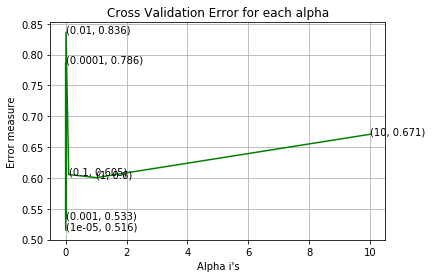

For values of best alpha =  1e-05 The train log loss is: 0.47908126974497567
For values of best alpha =  1e-05 The test log loss is: 0.5155795775340235
Total number of data points : 133416


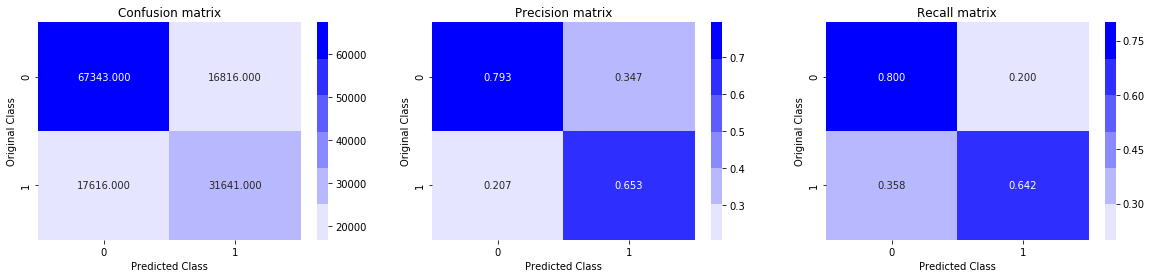

In [106]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, labels_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, labels_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, labels_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, labels_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(labels_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(labels_test, predicted_y)

#### Linear SVM

For values of alpha =  1e-05 The log loss is: 0.8744134393737314
For values of alpha =  0.0001 The log loss is: 0.6977160062928768
For values of alpha =  0.001 The log loss is: 0.7282432127335993
For values of alpha =  0.01 The log loss is: 0.5308769502670705
For values of alpha =  0.1 The log loss is: 0.6400130783629112
For values of alpha =  1 The log loss is: 0.7507695097271102
For values of alpha =  10 The log loss is: 0.8248518349397207


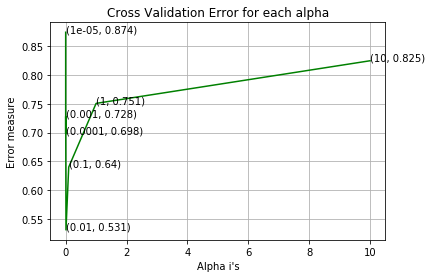

For values of best alpha =  0.01 The train log loss is: 0.5162450554447222
For values of best alpha =  0.01 The test log loss is: 0.5308769502670705
Total number of data points : 133416


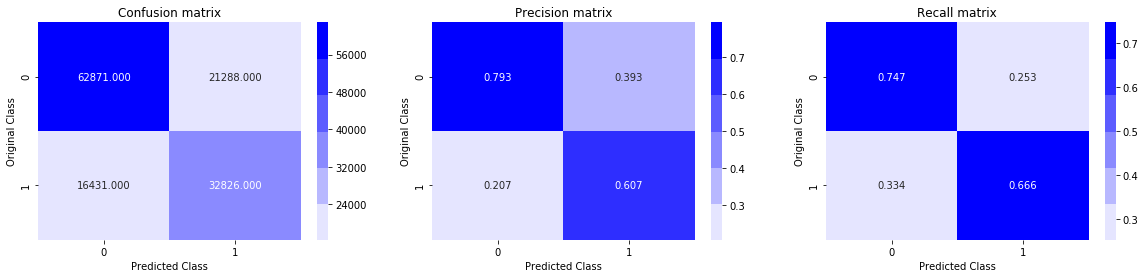

In [107]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, labels_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, labels_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, labels_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, labels_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(labels_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(labels_test, predicted_y)

In [195]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

words = []
for i in preprocessed_question:
    words.extend(i.split(' '))

print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

Loading Glove Model


1917495it [06:33, 4879.00it/s]


Done. 1917495  words loaded!
all the words in the coupus 3193695
the unique words in the coupus 73501
The number of words that are present in both glove vectors and our coupus 64706 ( 88.034 %)
word 2 vec length 64706


In [196]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys()) 

In [197]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model_essays = TfidfVectorizer()
tfidf_model_essays.fit_transform(preprocessed_question)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model_essays.get_feature_names(), list(tfidf_model_essays.idf_)))
tfidf_words = set(tfidf_model_essays.get_feature_names())

In [198]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_question): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████| 283003/283003 [00:24<00:00, 11684.86it/s]


283003
300


In [199]:
tfidf_model_essays.fit(preprocessed_question_test)
tfidf_model_essays.transform(preprocessed_question_test)

<121287x50712 sparse matrix of type '<class 'numpy.float64'>'
	with 1005876 stored elements in Compressed Sparse Row format>

In [200]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_question_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████| 121287/121287 [00:14<00:00, 8329.22it/s]


121287
300


In [201]:
from scipy.sparse import coo_matrix, hstack
X3_train = np.hstack((Qid1_standardized,Qid2_standardized,cwc_min_standardized,cwc_max_standardized,csc_min_standardized,csc_max_standardized,ctc_min_standardized,ctc_max_standardized,last_word_eq_standardized,first_word_eq_standardized,abs_len_diff_standardized,mean_len_standardized,token_set_ratio_standardized,token_sort_ratio_standardized,fuzz_ratio_standardized,fuzz_partial_ratio_standardized,longest_substr_ratio_standardized,tfidf_w2v_vectors))
X3_train.shape

(283003, 317)

In [202]:
X3_test = np.hstack((Qid1_test_standardized,Qid2_test_standardized,cwc_min_test_standardized,cwc_max_test_standardized,csc_min_test_standardized,csc_max_test_standardized,ctc_min_test_standardized,ctc_max_test_standardized,last_word_eq_test_standardized,first_word_eq_test_standardized,abs_len_diff_test_standardized,mean_len_test_standardized,token_set_ratio_test_standardized,token_sort_ratio_test_standardized,fuzz_ratio_test_standardized,fuzz_partial_ratio_test_standardized,longest_substr_ratio_test_standardized,tfidf_w2v_vectors_test))
X3_test.shape

(121287, 317)

#### XGBoost

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from math import log

In [111]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

C=xgb.XGBClassifier()

n_estimators=[100,200,300]
max_depth=[3,4,5]

parameters = {'n_estimators':n_estimators, 'max_depth':max_depth}
clf = GridSearchCV(C, parameters, cv=3, scoring='roc_auc',n_jobs=-1)
clf.fit(X3_train, labels_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scori

In [113]:
#print("Best: %f using %s" % (clf.best_score_, clf.best_params_))


#train_auc= clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.575357 (0.001675) with: {'max_depth': 3, 'n_estimators': 100}
-0.506644 (0.001575) with: {'max_depth': 3, 'n_estimators': 200}
-0.488037 (0.001361) with: {'max_depth': 3, 'n_estimators': 300}
-0.473507 (0.001281) with: {'max_depth': 4, 'n_estimators': 100}
-0.529077 (0.001017) with: {'max_depth': 4, 'n_estimators': 200}
-0.441083 (0.001043) with: {'max_depth': 4, 'n_estimators': 300}
-0.418470 (0.000924) with: {'max_depth': 5, 'n_estimators': 100}
-0.403365 (0.000540) with: {'max_depth': 5, 'n_estimators': 200}
-0.501542 (0.000857) with: {'max_depth': 5, 'n_estimators': 300}


The train log loss is: 0.42228321318770645
The test log loss is: 0.5092788069634366
Total number of data points : 121287


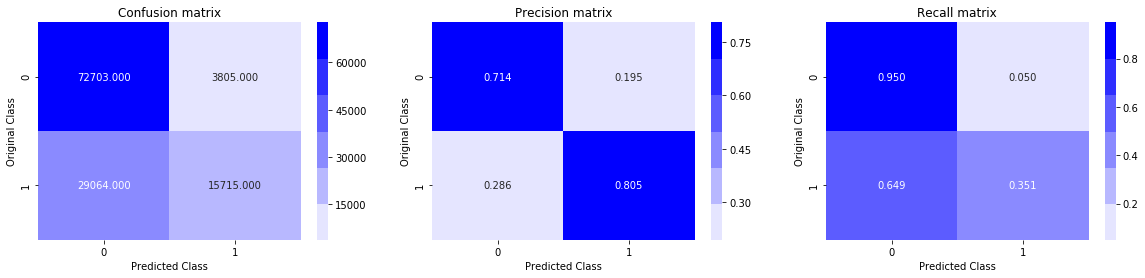

In [207]:
neigh = xgb.XGBClassifier(n_estimators=100,max_depth=3)
neigh.fit(X3_train, labels_train)
predict_y = neigh.predict_proba(X3_train)
print("The train log loss is:",log_loss(labels_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = neigh.predict_proba(X3_test)
print("The test log loss is:",log_loss(labels_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(labels_test, predicted_y)

#### Pretty Table

In [256]:
 from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train Log Loss", "Test Log Loss"]

x.add_row(["Logistic Regression",  0.47, 0.51])
x.add_row(["Linear SVM",0.51, 0.53])
x.add_row(["XGBoost- XGBClassifier", 0.42, 0.50])
print(x)

+------------------------+----------------+---------------+
|         Model          | Train Log Loss | Test Log Loss |
+------------------------+----------------+---------------+
|  Logistic Regression   |      0.47      |      0.51     |
|       Linear SVM       |      0.51      |      0.53     |
| XGBoost- XGBClassifier |      0.42      |      0.5      |
+------------------------+----------------+---------------+


#### Steps Followed:

1. The above problem is for finding the similarity between two questions in Quora
2. The Data Set has 401K odd points
3. We load the data set and start by doing simple EDA to find the important features like the Number of Repeated Questions, Unique Questions and do some basic feature engineering to find the word share, common words, total words.
4. Once we are are done with basic EDA we move towards Advanced Feature Extraction using NLP and FuzzyWuzzy
5. Here we get some very important features like cwc_min, cwc_max, fuzz_word_ratio, partial_fuzz_ratio, etc. We get 15 advanced Data Features
6. We perform EDA on the Advanced Extracted Features
7. We also perform TSNE on the Advanced Extracted Features for dimensionality reduction with no of dimensions as 2, perplexity as 30 and Perplexity as 1000.
8. We store the final data in nlp_features csv file.
9. The is_duplicate feature is the Y(Classification Value with Duplicate marked as 1 and not Duplicate marked as 0)
10. We then split the data in 70:30 ratio with 70% as the Train Data and 30% as the Test Data.
11. We then do Preprocessing of Data by removing the StopWords, special Characters in the string, etc
12. For Logistic Regression and Linear SVM we use TFIDF Vectorizer as they work well with more dimension.
13. For XGBClassifier we use TFIDF Weighted W2V as it works well with low dimension
14. For Numerical Values we have used MinMaxScaler to standardize the values
15. We Combine TFIDF features and the Standardize Numerical Values using Hstack and name the train set as X_train and test set as X_test
16. We then use X_train to Hyperarameter tuning for Logistic Regression and Linear SVM and use the best hyperparameter for X_test to find the performance of the model
17. We Combine TFIDF W2V features and the Standardize Numerical Values using Hstack and name the train set as X3_train and test set as X3_test
18. We then use X3_train to Hyperarameter tuning using Grid Search CV for XGBoost and use the best hyperparameter for X3_test to find the performance of the model
19. We use Log Loss as our Performance metric,
20. The log loss for all the models are nearly same.
21. The best log loss is for XGBClassifier with train log loss of 0.42 and test log loss of 0.5